In [1]:
# default_exp ocrlearner_training_2
%load_ext autoreload
%autoreload 2

# Experiment 2: OCR Learner Training 2: Match With Human Empirical Data

> Further train a CORnet-Z OCR model pretrained in a normal way to match data from empirical studies with human subjects.

1. Get confusion matrices from human studies.
2. Define a font dataset that is similar enough to the ones used in human studies.
3. Define augmentations so that they match the 50% accuracy used in human studies.
4. Extend the OCR Learner model so that we may target the propability distributions
   from human confusion matrices instead of one-hot vectors.
5. Finetune the CORnet-Z model to match.

In [52]:
#export

from aifont.core import *
from aifont.ocrlearner import *
from aifont.fontsampler import *
import cornet
from fastai.data.all import *
from fastai.vision.all import *
from enum import Enum, auto
import gc
import hashlib
from itertools import product
from nbdev.showdoc import *
import matplotlib.pyplot as plt
import os
import pandas as pd
from pandas import DataFrame
import PIL
import random
import re
import scipy.io
import string
import torchvision.transforms.functional as VF
import torchvision.transforms as VT
from typing import Callable, List, Sequence, Tuple

## Common Constants and Functions

In [48]:
#export

VD_HEIJDEN_PATH = Path("data/confusion_matrices/van_der_heijden_et_al_1984.csv")
TOWNSEND_PATH = Path("data/confusion_matrices/townsend_1971_cond_1.csv")
DUMP_FOLDER = Path("results")/"nb14_ocr_learner_training_2"
ensure_path(DUMP_FOLDER)

def load_confusion_matrix(
    path: Union[str, Path] = VD_HEIJDEN_PATH,
    symmetrize=False,
) -> DataFrame:
    """Load a saved empirical confusion matrix and format it a bit. Optionally
       `symmetrize` off-diagonal values."""
    cm = pd.read_csv(path)
    cm.rename(columns={cm.columns[0]: "Stimulus"}, inplace=True)
    cm.set_index("Stimulus", drop=True, inplace=True)
    if symmetrize: cm = (cm + cm.T) / 2
    return cm

def get_confusion_matrix(
    ocr_fn: str,
    n_out = 26,
    arch = cornet_for_ocr,
    splitter = cornet_splitter,
    df = get_sans_serif_df,
    tfms = EMPIRICAL_FINETUNING_TFMS,
    ds_idx = 0,
) -> DataFrame:
    """Compute a confusion matrix from output propabilites, not mere misclassifications."""
    ocr_model = load_ocr_model(file=ocr_fn, arch=arch, n_out=n_out)
    learn = build_ocr_learner(
        model=ocr_model, 
        splitter=splitter,
        df=df,
        loss_func=CrossEntropyLossFlat(flatten=False),
        **tfms
        )
    # Force augmentations to also work on the validation dataset, because `RandImgTfms` 
    # are only applied to the training dataset by default.
    for o in learn.dls.valid.after_item: o.split_idx = None
    preds,targets = learn.get_preds(ds_idx=ds_idx)
    vocab = learn.dls.vocab[0]
    preds_by_class = [[] for _ in vocab]
    for p,c in zip(preds,targets): 
        preds_by_class[c.item()].append(p)
    for i,p in enumerate(preds_by_class):
        preds_by_class[i] = [vocab[i]] + [o.item() for o in torch.stack(p).mean(dim=0)]
    cm = DataFrame(preds_by_class)
    cm.columns = ["Stimulus"] + vocab
    cm.set_index("Stimulus", inplace=True, drop=True)
    return cm

def compare_confusion_matrices(
    a: DataFrame,
    b: DataFrame,
    symmetrize=False,
    non_diagonal=False,
) -> DataFrame:
    """Calculate the Pearson correlation between two confusion matrices. For results
       comparable with traditional studies, set both `symmetrize` and `non_diagonal`
       to `True`."""
    from scipy.stats import pearsonr
    if symmetrize: a,b = (a + a.T) / 2, (b + b.T) / 2
    if non_diagonal:
        a_nd,b_nd = [],[]
        for i in range(len(a)): 
            a.iloc[i,i],b.iloc[i,i] = 0,0
            a_i,b_i = a.iloc[i].values.tolist(),b.iloc[i].values.tolist()
            del(a_i[i],b_i[i])
            a_nd.append(a_i); b_nd.append(b_i)
        index = a.index.tolist()
        a,b = DataFrame(a_nd),DataFrame(b_nd)
        a.index,b.index = index,index
    if symmetrize:
        # Remove duplicate entries before calculating total R
        lists = [[],[]]
        for i,o in enumerate([a,b]):
            for j in range(len(o)): 
                k = j if non_diagonal else j+1
                lists[i].append(o.values[j,:k].tolist())
        flat_r = pearsonr(*[flatten_list(o) for o in lists])
    else: 
        flat_r = pearsonr(*[flatten_list(o.values.tolist()) for o in (a,b)])
    per_cat_r = [("Total",) + flat_r]
    for c in a.index:
        per_cat_r.append((c,) + pearsonr(*[o.loc[c].values.tolist() for o in (a,b)]))
    per_cat_r = pd.DataFrame(per_cat_r)
    per_cat_r.columns = ["Stimulus", "Pearson R", "p"]
    per_cat_r.set_index("Stimulus", drop=True, inplace=True)
    return per_cat_r

In [50]:
df_vdh = load_confusion_matrix()
df_te = load_confusion_matrix(TOWNSEND_PATH)
compare_confusion_matrices(df_vdh, df_te, symmetrize=True, non_diagonal=True)

,Pearson R,p
Stimulus,,
Total,0.700038,3.680029e-49
A,0.564837,3.263549e-03
B,0.452853,2.301455e-02
C,0.777648,4.775560e-06
D,0.780187,4.241849e-06
E,0.475199,1.636839e-02
F,0.620697,9.308961e-04
G,0.674463,2.177518e-04
H,0.618938,9.718849e-04


## 0. Data for Text

Letter fine-tuning dataset statistics.

In [7]:
undersample_threshold = 2.
seed = 42
df_az  = get_a_z_handw_images(undersample=True, undersample_threshold=undersample_threshold, seed=seed)
df_tmnist = get_tmnist_images(undersample=True, undersample_threshold=undersample_threshold * .75, seed=seed)
df_az.head()

/Users/kallejarvenpaa/Desktop/AI-fontti/aifont/aifont/ocrlearner.py:101: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
181716,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147107,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141450,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188409,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157835,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
dist_ax = df_az['0'].value_counts()
dist_ax.sort_index(inplace=True)
dist_tmnist = df_tmnist['labels_num'].value_counts()
dist_tmnist.sort_index(inplace=True)
dist = pd.concat([dist_ax, dist_tmnist, DataFrame(list(VOCAB_UC))], axis=1)
dist.columns = ["Handwritten", "TMNIST", "Letter"]
dist.set_index("Letter", inplace=True)
dist

,Handwritten,TMNIST
Letter,,
A,2240,2874
B,2240,2874
C,2240,2874
D,2240,2874
E,2240,2874
F,1163,2874
G,2240,2874
H,2240,2874
I,1120,2874


Confusion matrix matching dataset statistics.

In [22]:
cm_fonts_df = get_sans_serif_df()
cm_fonts_df.head()

,Letter_idx,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,27_18,27_19,27_20,27_21,27_22,27_23,27_24,27_25,27_26,27_27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
dist_cm_fonts = cm_fonts_df['Letter_idx'].value_counts()
dist_cm_fonts.sort_index(inplace=True)
dist_cm_fonts = pd.concat([dist_cm_fonts, DataFrame(list(VOCAB_UC))], axis=1)
dist_cm_fonts.columns = ["Sans serif fonts", "Letter"]
dist_cm_fonts.set_index("Letter", inplace=True)
dist_cm_fonts

,Sans serif fonts
Letter,
A,250
B,250
C,250
D,250
E,250
F,250
G,250
H,250
I,250


## 1. Interruption: Retrain CORnet-Z with paramgroups frozen

> Now we notice that the earlier CORnet-Z models were trained with no frozen parameters. We should remedy this.

### 1.1 Training only the linear decoder – `cornet_fullds_blur_best.pth`

Let's retrain the CORnet-Z model with the same parameters as earlier (see notebook 0: OCR Learner Training 1) but with the body frozen.

However, comparing the mapping of CORnet's layers to brain areas and their receptive fields and proposed roles in letter recognition, restricting fine-tuning to the linear readout layer is quite limiting. And as we shall see, it does not yield satisfactory accuracy.

In [4]:
learn = None; gc.collect()
args = dict(arch=partial(cornet_for_ocr, split_at=CornetLayer.decoder),
            df=partial(get_combined_az_and_tmnist_df, False))
learn_fn = "cornet_fullds_blur_decoder"
best_fn = f"{learn_fn}_best"
latest_fn = f"{learn_fn}_latest"
save_cb = SaveModelCallback(monitor='valid_loss', 
                            fname=best_fn)
save2_cb = SaveModelCallback(every_epoch=True,
                             fname=latest_fn)
learn = get_ocr_learner_3(**args,
                            use_xtra_tfms=True, 
                            tfms_p=.8,
                            blur_size=(9, 15),
                            blur_sigma=(3., 5.), 
                            size=48, 
                            cbs=(save_cb, save2_cb),
                            normalize=True,
                            load_saved=False,
                            bs=256)
learn.freeze() # <<< This was missing earlier

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
learn.load(best_fn)
learn.fit_one_cycle(10, lrs.steep)
learn.save(f"{learn_fn}_ep11")
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
learn.fit_one_cycle(20, lrs.slide)
learn.save(f"{learn_fn}_ep31")
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
learn.fit_one_cycle(50, 1e-3)
learn.save(f"{learn_fn}_ep81")

The best model was one with valid_loss 0.4740999639034271 and accuracy of just 0.869065. This is saved as `cornet_fullds_blur_best.pth`.


### 1.2 Train V4, IT and the decoder – `cornet_fullds_blur_v4.pth`

This is a more plausible approach, although ideally we would train the V4 in an unsupervised manner.


In [ ]:
learn = None; gc.collect()
args = dict(arch=partial(cornet_for_ocr, split_at=CornetLayer.V4),
            df=partial(get_combined_az_and_tmnist_df, False))
learn_fn = "cornet_fullds_blur_v4"
best_fn = f"{learn_fn}_best"
latest_fn = f"{learn_fn}_latest"
save_cb = SaveModelCallback(monitor='valid_loss', 
                            fname=best_fn)
save2_cb = SaveModelCallback(every_epoch=True,
                             fname=latest_fn)
learn = get_ocr_learner_3(**args,
                            use_xtra_tfms=True, 
                            tfms_p=.8,
                            blur_size=(9, 15),
                            blur_sigma=(3., 5.), 
                            size=48, 
                            cbs=(save_cb, save2_cb),
                            normalize=True,
                            load_saved=False,
                            bs=256)
learn.freeze() # <<< This was missing earlier
learn.summary()

In [ ]:
learn.load(best_fn)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
learn.fit_one_cycle(20, lrs.valley)
learn.save(f"{learn_fn}_ep20")

Well, we already surpassed the previous attempt's accuracy on the first epoch and got an accuracy of 0.973746 on the 20th. Let's see if there's still room for improvement.

In [ ]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
learn.fit_one_cycle(20, lrs.steep)
learn.save(f"{learn_fn}_ep40")

Okay, an accuracy of 0.974663 seems to be the best we can get. The model is saved at `models/cornet_fullds_blur_v4.pth`.

## 2. Get confusion matrices from human studies

> Import the confusion matrices from the studies cited in Testolin et al. (2017).

However, taking into account the critique offered in van der Heijden et al. (1984), the difference in stimulus fonts in Townsend (1971, typewriter) and Gilmore et al. (1979, dot matrix), the low number of observations in Phillips et al. (1983, 60 per letter), and the low number of test subjects in Loomis (1982, 6 female subjects), we use only the data from van der Heijden et al. (1984).

See data/Letter confusion matrices combined.xlsx for all of the above and further information. For van der Heijden et al., the data is:

    Data source: van der Heijden et al.
    Year: 1984
    Font: Custom monoline sans-serif
    Letters: A–Z (uppercase)
    Visual Angle (Vertical Deg): 0,48
    Stimulus Deterioration: Duration (mean 6.42ms)
    Accuracy: 50%
    Subjects: 20
    Sex: 
    Displays / Letter / Subject: 60
    Total Displays / Letter: 1200
    Correlation With Testolin et al. (2017): 0,66

**Note** that in van def Heijden's data, the most probably response for the stimulus 'Q' was 'O'! This may be look confusing when using `show_batch` later.

In [ ]:
cm = pd.read_csv(VD_HEIJDEN_PATH)
cm.rename(columns={cm.columns[0]: "Stimulus"}, inplace=True)
cm.set_index("Stimulus", drop=True, inplace=True)
cm

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
Stimulus,,,,,,,,,,,,,,,,,,,,,
A,0.633,0.006,0.002,0.002,0.004,0.008,0.006,0.020,0.016,0.040,...,0.004,0.065,0.011,0.005,0.001,0.004,0.008,0.024,0.007,0.024
B,0.018,0.393,0.007,0.053,0.013,0.002,0.150,0.014,0.001,0.010,...,0.064,0.092,0.087,0.002,0.009,0.002,0.007,0.000,0.002,0.004
C,0.002,0.002,0.712,0.006,0.049,0.014,0.101,0.001,0.006,0.002,...,0.013,0.011,0.007,0.009,0.003,0.003,0.000,0.001,0.002,0.006
D,0.004,0.035,0.006,0.680,0.004,0.003,0.010,0.003,0.002,0.043,...,0.023,0.018,0.014,0.003,0.016,0.002,0.004,0.001,0.006,0.007
E,0.004,0.042,0.022,0.006,0.350,0.183,0.034,0.021,0.038,0.008,...,0.008,0.067,0.023,0.032,0.007,0.004,0.002,0.003,0.010,0.007
F,0.011,0.010,0.011,0.002,0.057,0.367,0.013,0.032,0.052,0.018,...,0.002,0.069,0.007,0.050,0.008,0.004,0.007,0.002,0.013,0.013
G,0.007,0.029,0.050,0.018,0.018,0.002,0.599,0.009,0.002,0.004,...,0.103,0.034,0.023,0.007,0.013,0.003,0.002,0.000,0.000,0.002
H,0.015,0.018,0.002,0.010,0.007,0.011,0.008,0.414,0.035,0.032,...,0.006,0.067,0.004,0.023,0.018,0.006,0.052,0.002,0.013,0.003
I,0.002,0.003,0.011,0.002,0.015,0.025,0.002,0.008,0.608,0.082,...,0.001,0.004,0.007,0.093,0.006,0.004,0.001,0.004,0.016,0.020


In [ ]:
# From Testolin et al. (2017)
# mat_fn = Path("data") / "confusion_matrices" / "testolin_et_al_2017" / "H1_similarity.mat"
# mat = scipy.io.loadmat(mat_fn)
# data = mat[list(mat.keys())[-1]]
# len(data)

## 3. Define a font dataset that is similar enough to the ones used in human studies

The van der Heijden study used a custom monoline sans-serif font. We'll create a DataFrame loader based on a list of font names and use that.

In [ ]:
#export

def get_font_df(
    font_paths: list[Union[str, Path]] = [SYS_FONT_PATH/"Arial.ttf"],
    font_size: float = 0.71,
    size: int = 28,
    vocab: list = VOCAB_UC
) -> DataFrame:
    """Create `DataFrame` by rendering the fonts."""
    data = []
    font_size = round(font_size * size)
    # Calculate a nice y position if we have an all-uppercase vocab
    y = font_size + (size - font_size) // 2 if ''.join(vocab).isupper() else None
    for font in font_paths:
        for i,l in enumerate(vocab):
            img = render_text(font, text=l, text_size=size, image_width=size, image_height=size, y=y, as_normalised_array=True)
            data.append([i] + list(255 * (1. - img.flatten())))
    df = pd.DataFrame(data).astype("uint8")
    df.columns = ["Letter_idx"] + [f"{i}_{j}" for i in range(size) for j in range(size)]
    return df

@delegates(get_font_df)
def get_fontsampler_df(
    variants: list[str] = None, 
    subsets: list[str] = None, 
    category: str = None, 
    **kwargs
) -> DataFrame:
    """Create a `DataFrame` by rendering fonts from `FontSampler`."""
    assert any([variants, subsets, category])
    return get_font_df(font_paths=FontSampler(variants=variants, subsets=subsets, category=category).paths, **kwargs)

We need a few search terms to get a suitable list of fonts.

In [ ]:
def get_sans_serif_df(): return get_fontsampler_df(category="sans-serif", variants=["regular"], subsets=["latin"])

## 4. Define augmentations so that they match the 50% accuracy used in human studies

First, we define some utilities to create DataLoaders and Learners with different augmentations.

In [ ]:
#export

def get_tfms(
    orig_sz:int,
    size=28,
    normalize=False, 
    tfms_p=.5,
    use_affine_tfms=True,
    use_xtra_tfms=False,
    blur_size:Union[int,Sequence[int]]=5,
    blur_sigma:Union[int,Sequence[int]]=(.1, 5.), 
    noise_f:Tuple[float,float]=(0., .6),
    translate_and_pad=0.,
) -> Tuple[list, list]:
    "Build `tfms` and `item_tfms` for use with `ImageDataLoadersDF.from_df`."
    tfms,item_tfms = [],[]
    if orig_sz < size: 
        pad = (size - orig_sz) // 2
        assert orig_sz + 2 * pad == size
        item_tfms += [Pad(pad, fill=255)]
    if normalize: tfms += [get_imagenet_norm()] # ToRGB(), 
    if use_xtra_tfms:
        max_rotate = 15.0
        max_warp = .25
        if translate_and_pad > 0:
            item_tfms += [TranslateAndPad(p=tfms_p, max_x=translate_and_pad, max_y=translate_and_pad)]
        if blur_sigma or blur_size:
            size_args = dict(random_size=blur_size) if is_listy(blur_size) else dict(kernel_size=(blur_size,)*2)
            item_tfms += [GaussianBlur(p=tfms_p, sigma=blur_sigma, **size_args)]
        if noise_f:
            item_tfms += [Noise(p=tfms_p, f=noise_f)]
    else: 
        max_rotate = 5.0
        max_warp = .1
    if use_affine_tfms:
        aug_tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
                    min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=tfms_p, 
                    p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                    pad_mode='reflection', align_corners=True, batch=False, 
                    min_scale=1.0)
        del(aug_tfms[1]) # Remove lighting tfm
        tfms += aug_tfms
    return tfms,item_tfms

@delegates(get_tfms)
def get_dls(
    df:Union[Callable, DataFrame], 
    bs=128, 
    start_col=1,
    vocab=VOCAB_UC,
    y_block=None, 
    seed=None,
    valid_pct=0.2,
    **kwargs
) -> DataLoaders:
    "Build `DataLoaders`."
    # Get DataFrame
    data = df() if callable(df) else df
    # Check if we need to pad
    orig_sz = math.isqrt(data.shape[1] - start_col)
    # Build tfms
    tfms,item_tfms = get_tfms(orig_sz=orig_sz, **kwargs)
    # tfms,item_tfms=None,None
    # Creata DataLoaders
    dls = ImageDataLoadersDF.from_df(data, vocab=vocab,
                                     width=orig_sz, height=orig_sz,
                                     num_workers=0, # Needed for Mac
                                     valid_pct=valid_pct, # Only training
                                     batch_tfms=tfms,
                                     item_tfms=item_tfms,
                                     color=False, #normalize,
                                     y_block=y_block,
                                     seed=seed, bs=bs)
    return dls

@delegates(get_dls)
def build_learner(
    model:Module=None, 
    splitter:Callable=cornet_splitter,
    arch:Callable=cornet_for_ocr,
    loss_func=CrossEntropyLossFlat(), 
    opt_func=Adam, 
    init=nn.init.kaiming_normal_,
    lr=defaults.lr, 
    cbs=None, 
    metrics=accuracy, 
    path=None, 
    model_dir=MODELS_PATH, 
    wd=None, 
    wd_bn_bias=False, 
    train_bn=True, 
    moms=(0.95,0.85,0.95),
    **kwargs
) -> Learner:
    """Create a new OCR learner based on `model` and `splitter` or an architecture
       generated by `arch` and dataset `df` (included in `**kwargs`)."""
    dls = get_dls(**kwargs)
    if model is None:
        n_out = get_c(dls)
        # This is a crappy, but we can specify the splitter in arch
        model_and_splitter = arch(n_out, input_shape=(dls.height, dls.width))
        if type(model_and_splitter) is tuple: model,splitter = model_and_splitter
        else: model,splitter = model_and_splitter,lambda m: L(m[0], m[1:]).map(params)
    else: assert splitter is not None
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, 
                    splitter=splitter, cbs=cbs,  metrics=metrics, path=path, model_dir=model_dir, 
                    wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)
    return learn

Get accuracy and find the right tranformations.

In [43]:
#export

@delegates(build_ocr_learner)
def get_model_accuracy_metrics(
    model:Module, 
    df:DataFrame,
    iters=1,
    show_batch=True,
    **kwargs
) -> Tuple[Learner, float, dict, float,  dict]:
    """Build a Learner and get accuracy metrics for it. Use `iters` to repeat 
       if dataset is small and using random augmentations. The tuple returned
       contains a copy of the `Learner` used, a mean of the propabilites for
       the correct class, a dict of these for each category, basic accurary,
       and basic accuracies for each class."""
    learn = build_ocr_learner(model, df=df, valid_pct=0., **kwargs)
    if show_batch: learn.dls.train.show_batch()
    preds_l,trgts_l = [],[]
    with learn.no_logging():
        for _ in range(iters):
            preds,trgts = (cast(o, Tensor) for o in learn.get_preds(ds_idx=0))
            preds_l.append(preds); trgts_l.append(trgts)
    preds,trgts = concat_tensors(preds_l),concat_tensors(trgts_l)
    trgt_preds = preds.gather(1, trgts.unsqueeze(1)).squeeze()
    vocab = learn.dls.vocab[0]
    prob_dict = {}
    acc_dict = {}
    for i,l in enumerate(vocab):
        mask = (trgts == i).nonzero().squeeze()
        prob_dict[l] = trgt_preds.gather(0, mask).mean().item()
        acc_dict[l]  = accuracy(preds.index_select(0, mask), torch.full_like(mask, i)).item()
    prob_mean = trgt_preds.mean().item()
    acc_mean = accuracy(preds, trgts)
    return learn,prob_mean,prob_dict,acc_mean,acc_dict

@delegates(get_model_accuracy_metrics)
def find_tfms_for_accuracy(
    model:Module, 
    df:DataFrame,
    target_acc=.5,
    target_prob=None,
    eps=.01,
    max_iters=40,
    param="blur_size", # or "blur_sigma"
    param_start=5,
    param_step=2,
    param_step_factor:float=0.5,
    base_tfms:dict=None,
    **kwargs
) -> Tuple[Learner,dict]:
    """Find values for tfms to pass to `get_tfms` that result in a mean accuracy of
       `target_acc` +/- `eps`, or `target_prob` which is the softmaxed probability
       of the target class. Note that by default we do not include affine rotation,
       scaling etc. transformations, nor noise. We only change blur."""
    assert param in ("blur_size", "blur_sigma")
    assert (target_acc is None) is not (target_prob is None)
    if param == "blur_size": 
        assert param_start % 2 == 1 and param_step % 2 == 0
        param_step_factor = math.ceil(param_step_factor)
    tfms_args = dict(
        use_affine_tfms=False,
        use_xtra_tfms=True, 
        tfms_p=1.,
        blur_size=5,
        blur_sigma=3., 
        noise_f=None,
        size=48, 
        normalize=True,
        translate_and_pad=0.
    )
    tfms_args[param] = param_start
    if base_tfms: tfms_args = {**tfms_args, **base_tfms}
    acc_mean = 10.
    step = param_step
    i = 0
    while abs(acc_mean - target_acc) > eps and i < max_iters:
        if i > 0:
            # Param should be raised but it's negative or it should be lowered but it's positive,
            # i.e., on the last iter we went past the target. Thus, reverse the sign of the step
            # and lower its abs value.
            if (acc_mean > target_acc and step < 0) or (acc_mean < target_acc and step > 0):
                if param_step_factor == 1: print("No more param options available."); break
                step *= -1 * param_step_factor
            tfms_args[param] += step                
        res = get_model_accuracy_metrics(model, df, **tfms_args, **kwargs)
        acc_mean,acc_dict = res[3:5] if target_prob is None else res[1:3]
        print(f"Iter {i} • Param ({param}): {tfms_args[param]} • Step {step} • Accuracy {acc_mean:.4f}")
        i += 1
    print("Final accuracy per letter")
    for l,a in acc_dict.items(): print(f"{l}: {a:.3f}")
    return res[0],tfms_args # res[0] is the Learner

### 4.1 Perform the search for the proper augmenations

Load the OCR model and a sans-serif and an Arial dataset.

In [15]:
learn = None; gc.collect()
# ocr_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur.pth"
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
arial_df = get_font_df([SYS_FONT_PATH/"Arial.ttf"])
base_tfms_args = dict(translate_and_pad=0.2)
df = get_sans_serif_df()
len(df)/len(VOCAB_UC)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


250.0

However, let's do a preliminary search with just Arial. Start first with blur_size with sigma at 6.0.

**Note that we do not want to use a sigma much higher than 6.0** as it introduces horisontal and vertical artifacts.

In [17]:
learn,tfms_args = find_tfms_for_accuracy(ocr_model, df=arial_df, target_acc=None, target_prob=.5,
    param_start=7, param_step=2, base_tfms=dict(blur_sigma=6., **base_tfms_args), bs=26, max_iters=13)

Iter 0 • Param (blur_size): 7 • Step 2 • Accuracy 0.9393


Iter 1 • Param (blur_size): 9 • Step 2 • Accuracy 0.8854


Iter 2 • Param (blur_size): 11 • Step 2 • Accuracy 0.8882


Iter 3 • Param (blur_size): 13 • Step 2 • Accuracy 0.7847


Iter 4 • Param (blur_size): 15 • Step 2 • Accuracy 0.5903


Iter 5 • Param (blur_size): 17 • Step 2 • Accuracy 0.3863
No more param options available.
Final accuracy per letter
A: 0.572
B: 0.276
C: 0.165
D: 0.209
E: 0.837
F: 0.050
G: 0.733
H: 0.651
I: 0.051
J: 0.244
K: 0.118
L: 0.499
M: 0.419
N: 0.200
O: 0.662
P: 0.481
Q: 0.325
R: 0.461
S: 0.080
T: 0.272
U: 0.222
V: 0.694
W: 0.313
X: 0.420
Y: 0.347
Z: 0.746


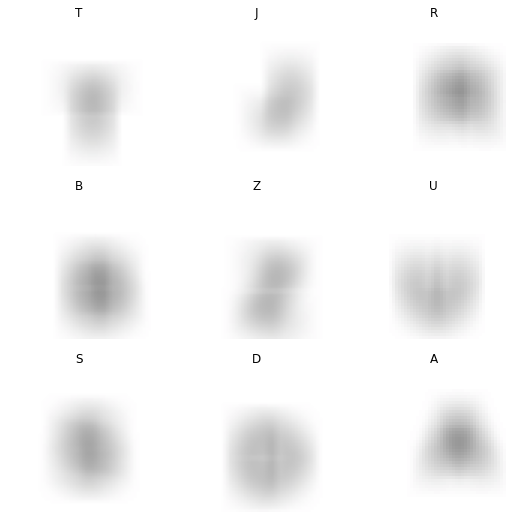

In [18]:
learn.dls.show_batch()

Next, search for a sigma using `blur_size = 17`.

In [20]:
learn,tfms_args = find_tfms_for_accuracy(ocr_model, df=arial_df, target_acc=None, target_prob=.5,
    param="blur_sigma", param_start=2., param_step=1., eps=.002, 
    base_tfms=dict(blur_size=17, **base_tfms_args), bs=26, max_iters=30)

Iter 0 • Param (blur_sigma): 2.0 • Step 1.0 • Accuracy 0.8307


Iter 1 • Param (blur_sigma): 3.0 • Step 1.0 • Accuracy 0.8653


Iter 2 • Param (blur_sigma): 4.0 • Step 1.0 • Accuracy 0.7542


Iter 3 • Param (blur_sigma): 5.0 • Step 1.0 • Accuracy 0.5691


Iter 4 • Param (blur_sigma): 6.0 • Step 1.0 • Accuracy 0.4307


Iter 5 • Param (blur_sigma): 5.5 • Step -0.5 • Accuracy 0.4368


Iter 6 • Param (blur_sigma): 5.0 • Step -0.5 • Accuracy 0.5788


Iter 7 • Param (blur_sigma): 5.25 • Step 0.25 • Accuracy 0.4955


Iter 8 • Param (blur_sigma): 5.125 • Step -0.125 • Accuracy 0.4937


Iter 9 • Param (blur_sigma): 5.0 • Step -0.125 • Accuracy 0.5768


Iter 10 • Param (blur_sigma): 5.0625 • Step 0.0625 • Accuracy 0.5153


Iter 11 • Param (blur_sigma): 5.125 • Step 0.0625 • Accuracy 0.4717


Iter 12 • Param (blur_sigma): 5.09375 • Step -0.03125 • Accuracy 0.4898


Iter 13 • Param (blur_sigma): 5.0625 • Step -0.03125 • Accuracy 0.5306


Iter 14 • Param (blur_sigma): 5.078125 • Step 0.015625 • Accuracy 0.4461


Iter 15 • Param (blur_sigma): 5.0703125 • Step -0.0078125 • Accuracy 0.4343


Iter 16 • Param (blur_sigma): 5.0625 • Step -0.0078125 • Accuracy 0.4738


Iter 17 • Param (blur_sigma): 5.0546875 • Step -0.0078125 • Accuracy 0.5548


Iter 18 • Param (blur_sigma): 5.05859375 • Step 0.00390625 • Accuracy 0.5243


Iter 19 • Param (blur_sigma): 5.0625 • Step 0.00390625 • Accuracy 0.5572


Iter 20 • Param (blur_sigma): 5.06640625 • Step 0.00390625 • Accuracy 0.5261


Iter 21 • Param (blur_sigma): 5.0703125 • Step 0.00390625 • Accuracy 0.5548


Iter 22 • Param (blur_sigma): 5.07421875 • Step 0.00390625 • Accuracy 0.4940


Iter 23 • Param (blur_sigma): 5.072265625 • Step -0.001953125 • Accuracy 0.5201


Iter 24 • Param (blur_sigma): 5.0732421875 • Step 0.0009765625 • Accuracy 0.4826


Iter 25 • Param (blur_sigma): 5.07275390625 • Step -0.00048828125 • Accuracy 0.5206


Iter 26 • Param (blur_sigma): 5.072998046875 • Step 0.000244140625 • Accuracy 0.5369


Iter 27 • Param (blur_sigma): 5.0732421875 • Step 0.000244140625 • Accuracy 0.5048


Iter 28 • Param (blur_sigma): 5.073486328125 • Step 0.000244140625 • Accuracy 0.5088


Iter 29 • Param (blur_sigma): 5.07373046875 • Step 0.000244140625 • Accuracy 0.4893
Final accuracy per letter
A: 0.598
B: 0.249
C: 0.852
D: 0.004
E: 0.950
F: 0.351
G: 0.352
H: 0.116
I: 0.065
J: 0.446
K: 0.860
L: 0.699
M: 0.699
N: 0.363
O: 0.679
P: 0.819
Q: 0.067
R: 0.388
S: 0.337
T: 0.303
U: 0.523
V: 0.607
W: 0.627
X: 0.643
Y: 0.611
Z: 0.511


For Arial, the results is

    blur_size = 17
    blur_sigma = 5.07373046875

Let's check the results for the wider font set.

In [21]:
learn2,tfms_args2 = find_tfms_for_accuracy(ocr_model, df=df, target_acc=None, target_prob=.5,
    param="blur_sigma", param_start=4., param_step=1., eps=.002, base_tfms=dict(blur_size=17, **base_tfms_args), max_iters=40)

Iter 0 • Param (blur_sigma): 4.0 • Step 1.0 • Accuracy 0.5913


Iter 1 • Param (blur_sigma): 5.0 • Step 1.0 • Accuracy 0.3839


Iter 2 • Param (blur_sigma): 4.5 • Step -0.5 • Accuracy 0.4805


Iter 3 • Param (blur_sigma): 4.0 • Step -0.5 • Accuracy 0.5895


Iter 4 • Param (blur_sigma): 4.25 • Step 0.25 • Accuracy 0.5336


Iter 5 • Param (blur_sigma): 4.5 • Step 0.25 • Accuracy 0.4782


Iter 6 • Param (blur_sigma): 4.375 • Step -0.125 • Accuracy 0.5037


Iter 7 • Param (blur_sigma): 4.4375 • Step 0.0625 • Accuracy 0.4907


Iter 8 • Param (blur_sigma): 4.40625 • Step -0.03125 • Accuracy 0.5005
Final accuracy per letter
A: 0.673
B: 0.445
C: 0.756
D: 0.366
E: 0.548
F: 0.363
G: 0.478
H: 0.397
I: 0.151
J: 0.361
K: 0.519
L: 0.621
M: 0.605
N: 0.506
O: 0.610
P: 0.722
Q: 0.329
R: 0.398
S: 0.659
T: 0.451
U: 0.485
V: 0.541
W: 0.380
X: 0.581
Y: 0.643
Z: 0.427


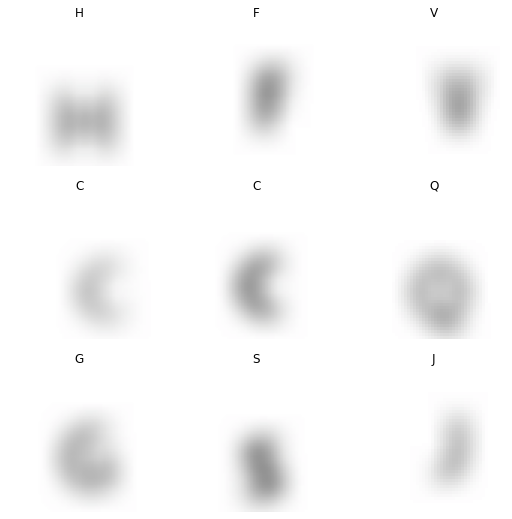

In [22]:
learn2.dls.show_batch()

Possible values for Arial only (all fonts) are:

| blur_size | translate_and_pad | blur_sigma for Arial | blur_sigma for sans-serif | notes |
| --  | -- | -- | -- | -- |
| 17 | 0.2 | 5.07 | 4.41 | V4, IT and decoder trained |
| 19 | 0.2 | 5.68 | 5.13 | all layers trained |

As the computations get slower the higher the blur_size, we'll prefer augmentations with a lower value for it.

Thus, we'll pick these augmentation arguments for the fine-tuning the CORnet model and define a getter for these for convenience.

In [ ]:
def get_finetuning_tfms_args(): return dict(
    use_affine_tfms=False,
    use_xtra_tfms=True, 
    tfms_p=1.,
    blur_size=17,
    blur_sigma=4.41, 
    noise_f=None,
    size=48, 
    normalize=True,
    translate_and_pad=.2
    )

### 4.2 Redo the Search Without Translate and Pad

In Notebook 15 we noticed that `translate_and_pad` causes a lot of noise, so let's redo the search without it.

In [5]:
learn = None; gc.collect()
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
arial_df = get_font_df([SYS_FONT_PATH/"Arial.ttf"])
df = get_sans_serif_df()
len(df)/len(VOCAB_UC)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


250.0

In [6]:
learn,tfms_args = find_tfms_for_accuracy(ocr_model, df=arial_df, target_acc=None, target_prob=.5,
    param_start=7, param_step=2, base_tfms=dict(blur_sigma=6.), bs=26*3, max_iters=13)

Iter 0 • Param (blur_size): 7 • Step 2 • Accuracy 0.9663


Iter 1 • Param (blur_size): 9 • Step 2 • Accuracy 0.9838


Iter 2 • Param (blur_size): 11 • Step 2 • Accuracy 0.9691


Iter 3 • Param (blur_size): 13 • Step 2 • Accuracy 0.9032


Iter 4 • Param (blur_size): 15 • Step 2 • Accuracy 0.7352


Iter 5 • Param (blur_size): 17 • Step 2 • Accuracy 0.5119


Iter 6 • Param (blur_size): 19 • Step 2 • Accuracy 0.2900
No more param options available.
Final accuracy per letter
A: 0.257
B: 0.248
C: 0.156
D: 0.253
E: 0.307
F: 0.060
G: 0.280
H: 0.197
I: 0.024
J: 0.095
K: 0.219
L: 0.242
M: 0.676
N: 0.304
O: 0.396
P: 0.375
Q: 0.497
R: 0.279
S: 0.169
T: 0.083
U: 0.408
V: 0.478
W: 0.451
X: 0.415
Y: 0.282
Z: 0.390


In [7]:
learn,tfms_args = find_tfms_for_accuracy(ocr_model, df=arial_df, 
    target_acc=None, target_prob=.5,
    param="blur_sigma", param_start=2., param_step=1., eps=.002, 
    base_tfms=dict(blur_size=17), bs=26*3, max_iters=30)

Iter 0 • Param (blur_sigma): 2.0 • Step 1.0 • Accuracy 0.9450


Iter 1 • Param (blur_sigma): 3.0 • Step 1.0 • Accuracy 0.9608


Iter 2 • Param (blur_sigma): 4.0 • Step 1.0 • Accuracy 0.9030


Iter 3 • Param (blur_sigma): 5.0 • Step 1.0 • Accuracy 0.6971


Iter 4 • Param (blur_sigma): 6.0 • Step 1.0 • Accuracy 0.5119


Iter 5 • Param (blur_sigma): 7.0 • Step 1.0 • Accuracy 0.3559


Iter 6 • Param (blur_sigma): 6.5 • Step -0.5 • Accuracy 0.4175


Iter 7 • Param (blur_sigma): 6.0 • Step -0.5 • Accuracy 0.5119


Iter 8 • Param (blur_sigma): 6.25 • Step 0.25 • Accuracy 0.4599


Iter 9 • Param (blur_sigma): 6.125 • Step -0.125 • Accuracy 0.4868


Iter 10 • Param (blur_sigma): 6.0 • Step -0.125 • Accuracy 0.5119


Iter 11 • Param (blur_sigma): 6.0625 • Step 0.0625 • Accuracy 0.4981
Final accuracy per letter
A: 0.435
B: 0.489
C: 0.303
D: 0.457
E: 0.791
F: 0.282
G: 0.522
H: 0.617
I: 0.065
J: 0.213
K: 0.496
L: 0.653
M: 0.756
N: 0.334
O: 0.561
P: 0.583
Q: 0.536
R: 0.421
S: 0.143
T: 0.434
U: 0.611
V: 0.477
W: 0.631
X: 0.796
Y: 0.513
Z: 0.830


For Arial:

    blur_size=17, blur_sigma=6.0625

In [8]:
learn2,tfms_args2 = find_tfms_for_accuracy(ocr_model, df=df, target_acc=None, target_prob=.5,
    param="blur_sigma", param_start=5., param_step=1., eps=.002, base_tfms=dict(blur_size=17), max_iters=40)

Iter 0 • Param (blur_sigma): 5.0 • Step 1.0 • Accuracy 0.5167


Iter 1 • Param (blur_sigma): 6.0 • Step 1.0 • Accuracy 0.3502


Iter 2 • Param (blur_sigma): 5.5 • Step -0.5 • Accuracy 0.4250


Iter 3 • Param (blur_sigma): 5.0 • Step -0.5 • Accuracy 0.5167


Iter 4 • Param (blur_sigma): 5.25 • Step 0.25 • Accuracy 0.4685


Iter 5 • Param (blur_sigma): 5.125 • Step -0.125 • Accuracy 0.4887


Iter 6 • Param (blur_sigma): 5.0 • Step -0.125 • Accuracy 0.5167


Iter 7 • Param (blur_sigma): 5.0625 • Step 0.0625 • Accuracy 0.5011
Final accuracy per letter
A: 0.636
B: 0.450
C: 0.639
D: 0.406
E: 0.427
F: 0.164
G: 0.410
H: 0.392
I: 0.161
J: 0.287
K: 0.354
L: 0.601
M: 0.756
N: 0.522
O: 0.543
P: 0.716
Q: 0.608
R: 0.391
S: 0.664
T: 0.286
U: 0.553
V: 0.513
W: 0.692
X: 0.625
Y: 0.649
Z: 0.584


For the whole sans-serif dataset:

    blur_size=17, blur_sigma=5.0625

Note that Arial truly seems to be quite legible compared to the other fonts.

In [ ]:
learn.dls.show_batch()

### 4.3 Redo the Search Using a Basic Accuracy as Target

In the earlier attempts, we used the propability of the target class as the accuracy metric. This leads, however, to a standard accuracy (correct argmax) of roughly 95%, which is far from the psychophysic paradigm.

We've made changes to `find_tfms_for_accuracy` so that it now defaults to using basic accuracy as the target.

In [36]:
learn = None; gc.collect()
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
arial_df = get_font_df([SYS_FONT_PATH/"Arial.ttf"])
df = get_sans_serif_df()
len(df)/len(VOCAB_UC)

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


250.0

In [44]:
learn,tfms_args = find_tfms_for_accuracy(ocr_model, df=arial_df,
    param_start=7, param_step=2, base_tfms=dict(blur_sigma=6.), bs=26*3,
    show_batch=False, iters=5)

Iter 0 • Param (blur_size): 7 • Step 2 • Accuracy 1.0000


Iter 1 • Param (blur_size): 9 • Step 2 • Accuracy 1.0000


Iter 2 • Param (blur_size): 11 • Step 2 • Accuracy 1.0000


Iter 3 • Param (blur_size): 13 • Step 2 • Accuracy 0.9615


Iter 4 • Param (blur_size): 15 • Step 2 • Accuracy 0.8846


Iter 5 • Param (blur_size): 17 • Step 2 • Accuracy 0.8846


Iter 6 • Param (blur_size): 19 • Step 2 • Accuracy 0.6923


Iter 7 • Param (blur_size): 21 • Step 2 • Accuracy 0.4615
No more param options available.
Final accuracy per letter
A: 1.000
B: 1.000
C: 0.000
D: 0.000
E: 1.000
F: 0.000
G: 0.000
H: 0.000
I: 0.000
J: 0.000
K: 0.000
L: 0.000
M: 1.000
N: 0.000
O: 1.000
P: 0.000
Q: 1.000
R: 1.000
S: 0.000
T: 0.000
U: 0.000
V: 1.000
W: 1.000
X: 1.000
Y: 1.000
Z: 1.000


In [45]:
blur_size = 21
learn,tfms_args = find_tfms_for_accuracy(ocr_model, df=arial_df, 
    param="blur_sigma", param_start=2., param_step=1., eps=.002, 
    base_tfms=dict(blur_size=blur_size), bs=26*3, max_iters=30,
    show_batch=False, iters=5)

Iter 0 • Param (blur_sigma): 2.0 • Step 1.0 • Accuracy 0.9615


Iter 1 • Param (blur_sigma): 3.0 • Step 1.0 • Accuracy 1.0000


Iter 2 • Param (blur_sigma): 4.0 • Step 1.0 • Accuracy 0.9615


Iter 3 • Param (blur_sigma): 5.0 • Step 1.0 • Accuracy 0.9231


Iter 4 • Param (blur_sigma): 6.0 • Step 1.0 • Accuracy 0.4615


Iter 5 • Param (blur_sigma): 5.5 • Step -0.5 • Accuracy 0.6923


Iter 6 • Param (blur_sigma): 5.75 • Step 0.25 • Accuracy 0.6538


Iter 7 • Param (blur_sigma): 6.0 • Step 0.25 • Accuracy 0.4615


Iter 8 • Param (blur_sigma): 5.875 • Step -0.125 • Accuracy 0.5769


Iter 9 • Param (blur_sigma): 5.9375 • Step 0.0625 • Accuracy 0.5000
Final accuracy per letter
A: 1.000
B: 1.000
C: 0.000
D: 1.000
E: 1.000
F: 0.000
G: 0.000
H: 0.000
I: 0.000
J: 0.000
K: 0.000
L: 0.000
M: 1.000
N: 0.000
O: 1.000
P: 0.000
Q: 1.000
R: 1.000
S: 1.000
T: 0.000
U: 0.000
V: 1.000
W: 0.000
X: 1.000
Y: 1.000
Z: 1.000


Results for Arial with accuracy 0.5000
    
    blur_size = 21
    blur_sigma = 5.9375

Let's perform the search for the whole dataset.

In [46]:
blur_size = 21
learn2,tfms_args2 = find_tfms_for_accuracy(ocr_model, df=df,
    param="blur_sigma", param_start=5., param_step=1., eps=.002, base_tfms=dict(blur_size=blur_size), 
    show_batch=False, iters=3)

Iter 0 • Param (blur_sigma): 5.0 • Step 1.0 • Accuracy 0.6598


Iter 1 • Param (blur_sigma): 6.0 • Step 1.0 • Accuracy 0.3177


Iter 2 • Param (blur_sigma): 5.5 • Step -0.5 • Accuracy 0.4825


Iter 3 • Param (blur_sigma): 5.0 • Step -0.5 • Accuracy 0.6598


Iter 4 • Param (blur_sigma): 5.25 • Step 0.25 • Accuracy 0.5660


Iter 5 • Param (blur_sigma): 5.5 • Step 0.25 • Accuracy 0.4825


Iter 6 • Param (blur_sigma): 5.375 • Step -0.125 • Accuracy 0.5231


Iter 7 • Param (blur_sigma): 5.4375 • Step 0.0625 • Accuracy 0.5035


Iter 8 • Param (blur_sigma): 5.5 • Step 0.0625 • Accuracy 0.4825


Iter 9 • Param (blur_sigma): 5.46875 • Step -0.03125 • Accuracy 0.4983
Final accuracy per letter
A: 0.860
B: 0.852
C: 0.296
D: 0.432
E: 0.320
F: 0.064
G: 0.148
H: 0.048
I: 0.020
J: 0.232
K: 0.112
L: 0.372
M: 0.832
N: 0.712
O: 0.604
P: 0.548
Q: 0.800
R: 0.756
S: 0.932
T: 0.028
U: 0.616
V: 0.644
W: 0.840
X: 0.580
Y: 0.884
Z: 0.424


Let's check what do we get with a smaller blur size.

In [47]:
blur_size = 19
learn2,tfms_args2 = find_tfms_for_accuracy(ocr_model, df=df,
    param="blur_sigma", param_start=5.5, param_step=1., eps=.002, base_tfms=dict(blur_size=blur_size), 
    show_batch=False, iters=3)

Iter 0 • Param (blur_sigma): 5.5 • Step 1.0 • Accuracy 0.5572


Iter 1 • Param (blur_sigma): 6.5 • Step 1.0 • Accuracy 0.2955


Iter 2 • Param (blur_sigma): 6.0 • Step -0.5 • Accuracy 0.4235


Iter 3 • Param (blur_sigma): 5.5 • Step -0.5 • Accuracy 0.5572


Iter 4 • Param (blur_sigma): 5.75 • Step 0.25 • Accuracy 0.4869


Iter 5 • Param (blur_sigma): 5.625 • Step -0.125 • Accuracy 0.5195


Iter 6 • Param (blur_sigma): 5.6875 • Step 0.0625 • Accuracy 0.5029


Iter 7 • Param (blur_sigma): 5.75 • Step 0.0625 • Accuracy 0.4869


Iter 8 • Param (blur_sigma): 5.71875 • Step -0.03125 • Accuracy 0.4955


Iter 9 • Param (blur_sigma): 5.6875 • Step -0.03125 • Accuracy 0.5029


Iter 10 • Param (blur_sigma): 5.703125 • Step 0.015625 • Accuracy 0.4974


Iter 11 • Param (blur_sigma): 5.6953125 • Step -0.0078125 • Accuracy 0.5009
Final accuracy per letter
A: 0.800
B: 0.832
C: 0.352
D: 0.448
E: 0.404
F: 0.036
G: 0.352
H: 0.044
I: 0.024
J: 0.172
K: 0.144
L: 0.564
M: 0.848
N: 0.656
O: 0.640
P: 0.632
Q: 0.776
R: 0.728
S: 0.864
T: 0.044
U: 0.512
V: 0.516
W: 0.808
X: 0.584
Y: 0.880
Z: 0.364


For the whole dataset

    blur_size = 21 • 19
    blur_sigma = 5.46875 • 5.6953125

Let's choose the value with the lower sigma, to reduce artifacts.

In [50]:
# Yet aother version of these tfms with 50% basic accuracy
EMPIRICAL_FINETUNING_3_TFMS = dict(
    use_affine_tfms=False,
    use_xtra_tfms=True, 
    tfms_p=1.,
    blur_size=21,
    blur_sigma=5.46875, 
    noise_f=None,
    size=48, 
    normalize=True,
    translate_and_pad=0.
)


## 5. Extend OCR Learner to target propability distributions instead of 1-hot vectors

Create relevant data blocks and transforms for category distributions.

In [49]:
#export

class TensorCategoryDistribution(TensorCategory): pass

TensorBase.register_func(Tensor.__getitem__, TensorCategoryDistribution)

class GetCategoryDistribution(DisplayedTransform):
    """Transform category string to propability distribution from `confusion_matrix`.
       Enforces a sum of one for each input's propabilities if `normalize`."""
    loss_func,order,y_tensors=CrossEntropyLossFlat(),1,{}
    def __init__(self, 
        confusion_matrix: DataFrame,
        vocab = None, 
        sort = True,
        normalize = True
        ):
        if vocab is not None: vocab = CategoryMap(vocab, sort=sort)
        store_attr()

    def setups(self, dsets):
        if self.vocab is None and dsets is not None: self.vocab = CategoryMap(dsets, sort=self.sort)
        self.c = len(self.vocab)
        for o in self.vocab:
            assert o in self.confusion_matrix.index
            t = tensor(self.confusion_matrix.loc[o])
            self.y_tensors[o] = t / t.sum() if self.normalize else t

    def encodes(self, o): 
        try:
            return self.y_tensors[o]
        except KeyError as e:
            raise KeyError(f"Label '{o}' was not included in the training dataset") from e

def CategoryDistibutionBlock(
    confusion_matrix: DataFrame,
    vocab = None, 
    sort = True,
    normalize = True
):
    "`TransformBlock` category propability distributions."
    return TransformBlock(type_tfms=GetCategoryDistribution(confusion_matrix=confusion_matrix, 
                          vocab=vocab, sort=sort, normalize=normalize))

## 6. Finetune the CORnet-Z model to match the confusion matrix data

### 6.1 Finetune V4–decoder – `cornet_v4_matching_vdh_conf_matrix.pth`

We have done this once without freezing the layers.

In [32]:
learn = None; gc.collect()
# ocr_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur.pth"
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
df = get_sans_serif_df()
cm = pd.read_csv(VD_HEIJDEN_PATH)
cm.rename(columns={cm.columns[0]: "Stimulus"}, inplace=True)
cm.set_index("Stimulus", drop=True, inplace=True)
y_block = partial(CategoryDistibutionBlock, confusion_matrix=cm, vocab=VOCAB_UC)
learn_fn = f"cornet_v4_matching_vdh_conf_matrix"
learn = build_ocr_learner(
    model=ocr_model, 
    splitter=partial(cornet_splitter, split_at=CornetLayer.V4),
    df=df,
    y_block=y_block,
    loss_func=CrossEntropyLossFlat(flatten=False),
    metrics=None,
    **EMPIRICAL_FINETUNING_TFMS
    )
learn.freeze()
learn.summary()

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Sequential (Input shape: 128 x 3 x 48 x 48)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 24 x 24  
Conv2d                                    9472       False     
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 12 x 12  
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     128 x 128 x 12 x 12 
Conv2d                                    73856      False     
ReLU                                                           
____________________________________________________________________________
                     128 x 128 x 6 x 6   
MaxPool2d                                                      
Identity                                     

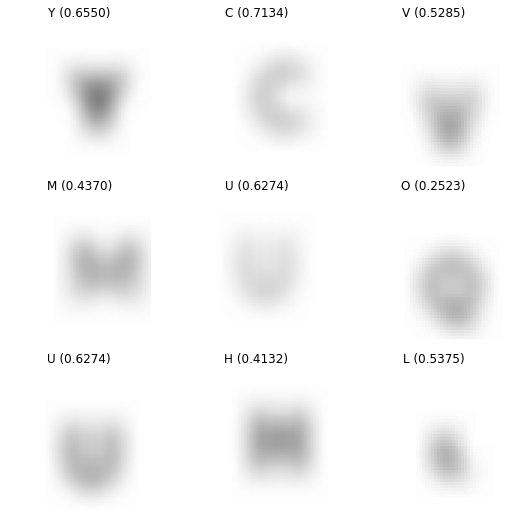

In [33]:
learn.dls.show_batch()

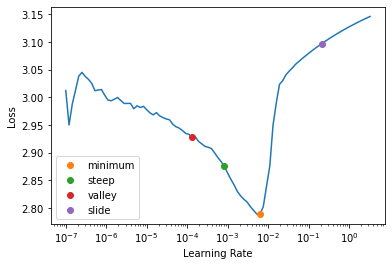

In [34]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [35]:
learn.fit_one_cycle(30, lrs.minimum)
learn.save(f"{learn_fn}_ep30")

epoch,train_loss,valid_loss,time
0,2.796758,8.687829,00:37
1,2.642308,7.442153,00:40
2,2.496084,6.527653,00:38
3,2.394420,6.028926,00:37
4,2.325419,5.596772,00:37
5,2.276828,5.384676,00:38
6,2.243339,5.148836,00:38
7,2.213207,5.282938,00:37
8,2.195736,5.343576,00:37
9,2.179255,5.625172,00:38


Path('models/cornet_v4_matching_vdh_conf_matrix_ep30.pth')

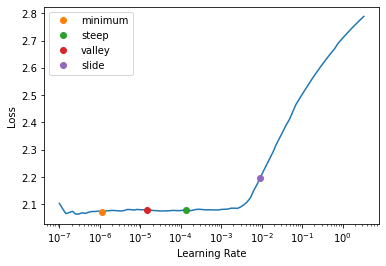

In [36]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [37]:
learn.fit_one_cycle(100, lrs.slide)
learn.save(f"{learn_fn}_ep130")

epoch,train_loss,valid_loss,time
0,2.090182,8.869219,00:36
1,2.089712,9.164594,00:37
2,2.091953,10.238033,00:35
3,2.089239,10.166002,00:35
4,2.092759,10.120854,00:35
5,2.093575,11.828792,00:35
6,2.096209,13.083879,00:36
7,2.103394,14.551666,00:35
8,2.113825,13.158628,00:35
9,2.131820,14.535556,00:35


Path('models/cornet_v4_matching_vdh_conf_matrix_ep130.pth')

In [38]:
learn.fit_one_cycle(50, lrs.slide)
learn.save(f"{learn_fn}_ep80")

epoch,train_loss,valid_loss,time
0,1.975528,109.826614,00:37
1,1.977875,108.688622,00:37
2,1.980847,109.697334,00:37
3,1.985414,110.645538,00:37
4,1.989942,110.505051,00:37
5,1.997067,115.843414,00:37
6,2.004459,110.405952,00:37
7,2.015222,108.750916,00:37
8,2.024727,115.213989,00:37
9,2.029300,116.184822,00:37


Path('models/cornet_v4_matching_vdh_conf_matrix_ep80.pth')

In [39]:
learn.fit_one_cycle(100, 2 * lrs.slide)
learn.save(f"{learn_fn}_ep180")

epoch,train_loss,valid_loss,time
0,1.969780,129.560364,00:35
1,1.969852,131.478577,00:35
2,1.969276,129.690781,00:35
3,1.971749,130.648987,00:35
4,1.975742,127.437828,00:35
5,1.979918,131.653046,00:37
6,1.985552,129.963715,00:35
7,1.988217,129.038010,00:36
8,1.993126,129.595306,00:37
9,1.995777,130.457886,00:36


Path('models/cornet_v4_matching_vdh_conf_matrix_ep180.pth')

With the V4, IT and decoder trained model, we seem to reach a minimum loss of ca. 1.964821. We'll save the model as `models/cornet_v4_matching_vdh_conf_matrix.pth`.

### 6.2 Rerun 1: Finetune decoder only – `cornet_v4_matching_decoder_vdh_conf_matrix.pth`

See discussion in Notebook 15.

In [11]:
learn = None; gc.collect()
# ocr_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur.pth"
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
df = get_sans_serif_df()
cm = pd.read_csv(VD_HEIJDEN_PATH)
cm.rename(columns={cm.columns[0]: "Stimulus"}, inplace=True)
cm.set_index("Stimulus", drop=True, inplace=True)
y_block = partial(CategoryDistibutionBlock, confusion_matrix=cm, vocab=VOCAB_UC)
learn_fn = f"cornet_v4_matching_decoder_vdh_conf_matrix"
learn = build_ocr_learner(
    model=ocr_model, 
    splitter=partial(cornet_splitter, split_at=CornetLayer.decoder), # Was CornetLayer.V4
    df=df,
    y_block=y_block,
    loss_func=CrossEntropyLossFlat(flatten=False),
    metrics=None,
    **EMPIRICAL_FINETUNING_TFMS
    )
learn.freeze()
learn.summary()

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Sequential (Input shape: 128 x 3 x 48 x 48)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 24 x 24  
Conv2d                                    9472       False     
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 12 x 12  
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     128 x 128 x 12 x 12 
Conv2d                                    73856      False     
ReLU                                                           
____________________________________________________________________________
                     128 x 128 x 6 x 6   
MaxPool2d                                                      
Identity                                     

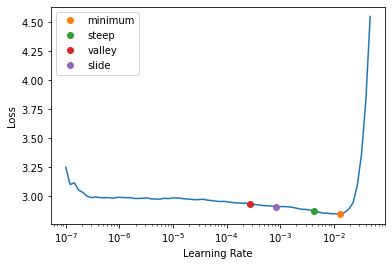

In [12]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [13]:
learn.fit_one_cycle(200, lrs.minimum)
learn.save(f"{learn_fn}_ep200")

epoch,train_loss,valid_loss,time
0,2.853404,9.721362,00:31
1,2.805149,9.657009,00:29
2,2.764833,9.575531,00:31
3,2.721085,9.474109,00:31
4,2.680392,9.379694,00:28
5,2.638162,9.269060,00:29
6,2.601827,9.130921,00:28
7,2.553008,8.999885,00:28
8,2.509003,8.858795,00:28
9,2.469116,8.728259,00:29


Path('models/cornet_v4_matching_decoder_vdh_conf_matrix_ep200.pth')

After 200 epochs, we are at 2.069566. Let's see if we can get this down.

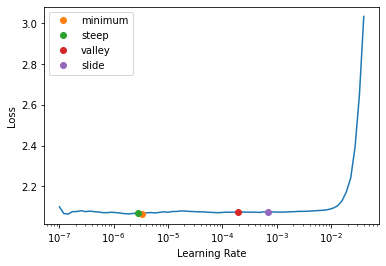

In [14]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [15]:
learn.fit_one_cycle(100, 1e-3)
learn.save(f"{learn_fn}_ep300")

epoch,train_loss,valid_loss,time
0,2.071359,12.907069,00:30
1,2.070645,12.905484,00:31
2,2.074203,12.909273,00:29
3,2.073812,12.900398,00:29
4,2.070631,12.875443,00:34
5,2.071187,12.897540,00:31
6,2.073967,12.887995,00:30
7,2.072666,12.977114,00:29
8,2.074953,13.016670,00:29
9,2.075691,12.958574,00:29


Path('models/cornet_v4_matching_decoder_vdh_conf_matrix_ep300.pth')

We're making a bit of progress, from 2.069566 to 2.067496, but the learning rate was probably too high.

In [16]:
learn.fit_one_cycle(100, 2e-4)
learn.save(f"{learn_fn}_ep400")

epoch,train_loss,valid_loss,time
0,2.067337,14.389657,00:31
1,2.066185,14.408074,00:28
2,2.067254,14.394943,27:40
3,2.066849,14.394490,00:40
4,2.065879,14.407093,00:31
5,2.065685,14.423658,00:28
6,2.066977,14.400628,00:28
7,2.066121,14.433355,00:28
8,2.067794,14.449718,00:28
9,2.066443,14.393850,00:28


Path('models/cornet_v4_matching_decoder_vdh_conf_matrix_ep400.pth')

In [17]:
learn.fit_one_cycle(300, 1e-4)
learn.save(f"{learn_fn}_ep700")

epoch,train_loss,valid_loss,time
0,2.066476,14.642754,00:32
1,2.066616,14.644860,00:30
2,2.063969,14.647883,00:29
3,2.065799,14.652341,00:29
4,2.065187,14.649719,00:30
5,2.066332,14.642303,00:29
6,2.065947,14.652122,00:29
7,2.067888,14.654052,00:29
8,2.067165,14.647109,00:29
9,2.067462,14.646558,00:29


Path('models/cornet_v4_matching_decoder_vdh_conf_matrix_ep700.pth')

It seems a loss of 2.063479 is pretty much how low we can get. With the V4–decoder-trained model with got to train_loss of 1.964821. We'll save the model as `cornet_v4_matching_decoder_vdh_conf_matrix.pth`.

### 6.3 Rerun 2: Finetune Decoder Without `translate_and_pad` – `cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2.pth`

In [83]:
learn = None; gc.collect()
# ocr_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur.pth"
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
df = get_sans_serif_df()
cm = pd.read_csv(VD_HEIJDEN_PATH)
cm.rename(columns={cm.columns[0]: "Stimulus"}, inplace=True)
cm.set_index("Stimulus", drop=True, inplace=True)
y_block = partial(CategoryDistibutionBlock, confusion_matrix=cm, vocab=VOCAB_UC)
learn_fn = f"cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2"
tfms = EMPIRICAL_FINETUNING_2_TFMS
learn = build_ocr_learner(
    model=ocr_model, 
    splitter=partial(cornet_splitter, split_at=CornetLayer.decoder), # Was CornetLayer.V4
    df=df,
    y_block=y_block,
    loss_func=CrossEntropyLossFlat(flatten=False),
    metrics=None,
    **tfms
    )
print(tfms)
learn.freeze()
learn.summary()

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


{'use_affine_tfms': False, 'use_xtra_tfms': True, 'tfms_p': 1.0, 'blur_size': 17, 'blur_sigma': 5.0625, 'noise_f': None, 'size': 48, 'normalize': True, 'translate_and_pad': 0.0}


Sequential (Input shape: 128 x 3 x 48 x 48)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 24 x 24  
Conv2d                                    9472       False     
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 12 x 12  
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     128 x 128 x 12 x 12 
Conv2d                                    73856      False     
ReLU                                                           
____________________________________________________________________________
                     128 x 128 x 6 x 6   
MaxPool2d                                                      
Identity                                     

Add a callback.

In [88]:
learn.add_cb(SaveModelCallback(fname=f"{learn_fn}_best"))

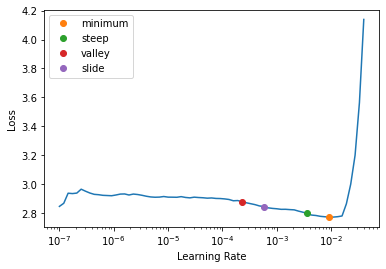

In [86]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

Force augmentations to also work on the validation dataset, because `RandImgTfms` are only applied to the training dataset by default.

In [87]:

for o in learn.dls.valid.after_item: o.split_idx = None

In [89]:
learn.fit_one_cycle(300, lrs.minimum)
learn.save(f"{learn_fn}_ep300")

epoch,train_loss,valid_loss,time
0,2.763848,2.698120,00:33
1,2.698130,2.646610,00:33
2,2.660250,2.617126,00:32
3,2.629456,2.587224,00:35
4,2.597445,2.556784,00:35
5,2.568270,2.526137,00:34
6,2.537438,2.495418,00:33
7,2.505566,2.464303,00:35
8,2.475486,2.433455,00:33
9,2.444121,2.405612,00:36


Better model found at epoch 0 with valid_loss value: 2.698119640350342.
Better model found at epoch 1 with valid_loss value: 2.6466102600097656.
Better model found at epoch 2 with valid_loss value: 2.6171257495880127.
Better model found at epoch 3 with valid_loss value: 2.587223768234253.
Better model found at epoch 4 with valid_loss value: 2.5567843914031982.
Better model found at epoch 5 with valid_loss value: 2.526136875152588.
Better model found at epoch 6 with valid_loss value: 2.495417594909668.
Better model found at epoch 7 with valid_loss value: 2.4643025398254395.
Better model found at epoch 8 with valid_loss value: 2.4334545135498047.
Better model found at epoch 9 with valid_loss value: 2.405611753463745.
Better model found at epoch 10 with valid_loss value: 2.3791415691375732.
Better model found at epoch 11 with valid_loss value: 2.353668212890625.
Better model found at epoch 12 with valid_loss value: 2.3300583362579346.
Better model found at epoch 13 with valid_loss value: 

Path('models/cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2_ep300.pth')

The best model was found at epoch 285 with valid_loss value: 2.0143144130706787. It's saved as `cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2.pth`.

### DISCONTINUED 6.4 Rerun 3: Finetune With Tfms Based on Basic Accuracy

Still no `translate_and_pad` but with stronger impairments so that they match a 50% basic accuracy.

**Discontinued because we can actually treat the activation probabilities equal to a confusion matrix. The human cognitive process is stochastic by all accounts and thus the decoder's probabilites should reflect categorisation distributions.**

In [51]:
learn = None; gc.collect()
# ocr_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur.pth"
ocr_fn = "cornet_fullds_blur_v4.pth"
ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)
df = get_sans_serif_df()
cm = pd.read_csv(VD_HEIJDEN_PATH)
cm.rename(columns={cm.columns[0]: "Stimulus"}, inplace=True)
cm.set_index("Stimulus", drop=True, inplace=True)
y_block = partial(CategoryDistibutionBlock, confusion_matrix=cm, vocab=VOCAB_UC)
learn_fn = f"cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_basic_acc50"
tfms = EMPIRICAL_FINETUNING_3_TFMS # <<
learn = build_ocr_learner(
    model=ocr_model, 
    splitter=partial(cornet_splitter, split_at=CornetLayer.decoder), # Was CornetLayer.V4
    df=df,
    y_block=y_block,
    loss_func=CrossEntropyLossFlat(flatten=False),
    metrics=None,
    **tfms
    )
print(tfms)
learn.freeze()
learn.summary()

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


{'use_affine_tfms': False, 'use_xtra_tfms': True, 'tfms_p': 1.0, 'blur_size': 21, 'blur_sigma': 5.46875, 'noise_f': None, 'size': 48, 'normalize': True, 'translate_and_pad': 0.0}


Sequential (Input shape: 128 x 3 x 48 x 48)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 64 x 24 x 24  
Conv2d                                    9472       False     
ReLU                                                           
____________________________________________________________________________
                     128 x 64 x 12 x 12  
MaxPool2d                                                      
Identity                                                       
____________________________________________________________________________
                     128 x 128 x 12 x 12 
Conv2d                                    73856      False     
ReLU                                                           
____________________________________________________________________________
                     128 x 128 x 6 x 6   
MaxPool2d                                                      
Identity                                     

In [85]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

KeyboardInterrupt: 

Force augmentations to also work on the validation dataset, because `RandImgTfm` is only applied to the training dataset by default.

In [84]:
for o in learn.dls.valid.after_item: o.split_idx = None

In [77]:
learn.fit_one_cycle(300, lrs.minimum)
learn.save(f"{learn_fn}_ep300")

epoch,train_loss,valid_loss,time
0,2.451578,2.440557,00:38
1,2.439686,2.426305,00:40
2,2.429444,2.413878,00:40
3,2.417364,2.402245,00:41
4,2.406324,2.390902,3:15:56


KeyboardInterrupt: 

In [ ]:
learn.recorder.losses[-1]

In [ ]:
learn = None; gc.collect()
ocr_fn = "cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_basic_acc50.pth"
cm_ocr = get_confusion_matrix(ocr_fn, tfms=EMPIRICAL_FINETUNING_3_TFMS)
cm_emp = load_confusion_matrix()
per_cat_r = compare_confusion_matrices(cm_emp, cm_ocr)
cm_ocr.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_no_trapad_basic_acc50_confusion_matrix.csv")
per_cat_r.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_no_trapad_basic_acc50_and_vdh_correlation.csv")
per_cat_r

### Deprecated: The data below are for the completely unfrozen model

In [23]:
learn.fit_one_cycle(300, 3 * lrs.slide)
learn.save(f"{learn_fn}_ep480")

epoch,train_loss,valid_loss,accuracy,time
0,1.891532,None,None,00:55
1,1.893038,None,None,00:56
2,1.892843,None,None,00:55
3,1.893950,None,None,00:55
4,1.893080,None,None,00:55
5,1.891935,None,None,00:55
6,1.890547,None,None,00:55
7,1.891866,None,None,00:55
8,1.891407,None,None,00:55
9,1.893067,None,None,00:55


Path('models/cornet_matching_vdh_conf_matrix_ep480.pth')

Now, we are down to loss 1.888343. Let's still see if there's any room for improvement.

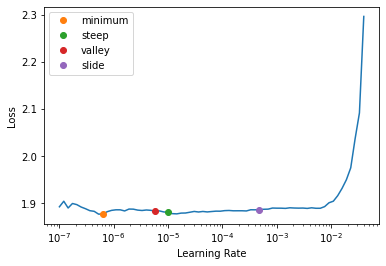

In [24]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [25]:
learn.fit_one_cycle(100, lrs.slide)
learn.save(f"{learn_fn}_ep580")

epoch,train_loss,valid_loss,accuracy,time
0,1.886726,None,None,01:00
1,1.886556,None,None,00:59
2,1.888225,None,None,00:58
3,1.888099,None,None,00:58
4,1.888072,None,None,00:59
5,1.887587,None,None,00:56
6,1.886696,None,None,00:55
7,1.887699,None,None,00:58
8,1.888247,None,None,00:57
9,1.888466,None,None,00:56


Path('models/cornet_matching_vdh_conf_matrix_ep580.pth')

So, that did not improve the accuracy. Just to be sure, let's see if raising the lr a lot has any effect.

In [26]:
learn.fit_one_cycle(300, 6 * lrs.slide)
learn.save(f"{learn_fn}_ep880")

epoch,train_loss,valid_loss,accuracy,time
0,1.885225,None,None,01:00
1,1.887295,None,None,01:00
2,1.887772,None,None,12:35
3,1.886968,None,None,3:59:06
4,1.886783,None,None,01:17
5,1.886537,None,None,00:57
6,1.887467,None,None,00:56
7,1.888299,None,None,00:56
8,1.886950,None,None,00:57
9,1.888007,None,None,01:00


Path('models/cornet_matching_vdh_conf_matrix_ep880.pth')

Well, this didn't move the final loss at all, so we'll have to be satisfied with that.

We'll rename the latest saved model to `cornet_all_matching_vdh_conf_matrix.pth`. 

It can be loaded with:

    ocr_fn = "cornet_all_matching_vdh_conf_matrix.pth"
    ocr_model = load_ocr_model(file=ocr_fn, arch=cornet_for_ocr, n_out=26)

In [28]:
learn.recorder.losses[-1].item()

1.8858036994934082

### Sidenote: Minimum loss is never zero

Just some tests with the loss function. It's will never yield a loss of zero and the minimum loss possible is dependent on the target distribution.

In [283]:
x,y = learn.dls.one_batch()
ocr_model.eval()
pred = ocr_model(x)
xelf = CrossEntropyLossFlat(flatten=False)
print(xelf(pred, y))
inp, tgt = tensor([[.95, .05]]), tensor([[.95, .05]])
print(F.softmax(inp,dim=1), xelf(inp, tgt), F.cross_entropy(inp, tgt))
print(F.softmax(pred[0], dim=0), y[0], xelf(pred[0].unsqueeze(dim=0), y[0].unsqueeze(dim=0)))

torch.Size([128, 26])

## 7. Analyse the OCR model

Finally, let's do a bit of analysis on the OCR mmodel's performance.

Taking our cue from Testolin et al. (2017, p. 660):

"The errors produced by the model under a noise level (standard deviation =0.7) yielding overall identification performance of 50% across all fonts were used to compute a confusion matrix, which was compared with six published empirical matrices derived from human errors (see Methods). Pearson’s correlations between each empirical confusion matrix and the model’s confusion matrix are reported in Fig. 3a. The mean correlation between model and human confusion matrices was 0.51 (P < 0.001), approaching the mean cross-correlation across the confusion matrices of the empirical studies (0.56)."

Note, however, that we did not use noise in training but Gaussian blur.

| Model | Pearson R | P-value |
| --- | --- | --- |
| `cornet_v4_matching_vdh_conf_matrix.pth` | 0.998192	| 0.000000e+00 |
| `cornet_v4_matching_decoder_vdh_conf_matrix.pth` | 0.991866 | 0.000000e+00 |
| `cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2` | 0.997251 | 0.000000e+00 |

### 7.1 Analysing the V4–decoder-trained model

Let's get a confusion matrix for the model.

Note that we can't use the existing `Learner` as we need a standard `DataLoader` that produces one-hot targets. This is achieved by simply not specifying an `y_block`.

However, as we're using the same dataset as in training, we won't get much confusion, so we better calculate the averages probabilites for each target class and compare those to the empirical data.

In [12]:
learn = None; gc.collect()
# ocr_fn = "cornet_all_vdh_conf_matrix.pth"
ocr_fn = "cornet_v4_matching_vdh_conf_matrix.pth"
cm_ocr = get_confusion_matrix(ocr_fn)
cm_ocr.head()

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
Stimulus,,,,,,,,,,,,,,,,,,,,,
A,0.602879,0.005419,0.007096,0.002189,0.006524,0.008275,0.012422,0.016214,0.020310,0.040437,...,0.012559,0.058940,0.016193,0.012848,0.004024,0.002174,0.004755,0.018783,0.011828,0.020997
B,0.013615,0.340811,0.011714,0.062035,0.015165,0.009692,0.133372,0.013104,0.006451,0.014502,...,0.058827,0.089601,0.083241,0.003882,0.011742,0.003185,0.006697,0.003411,0.009328,0.007340
C,0.005663,0.007452,0.660619,0.004138,0.053665,0.017152,0.112008,0.003685,0.006578,0.004539,...,0.015595,0.011418,0.008296,0.008808,0.006107,0.005509,0.002459,0.003096,0.002145,0.007545
D,0.002495,0.040693,0.014423,0.640382,0.003688,0.003067,0.024359,0.004806,0.002977,0.038623,...,0.027462,0.020275,0.015809,0.002275,0.014773,0.001128,0.003103,0.000790,0.004986,0.005800
E,0.008743,0.032366,0.039936,0.004798,0.318717,0.175420,0.035987,0.013967,0.030850,0.018801,...,0.008667,0.069171,0.019344,0.030817,0.010821,0.007810,0.006070,0.006649,0.012660,0.011756


Let's load the confusion matrix to compare to.

In [6]:
cm_emp = load_confusion_matrix()
cm_emp.head()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
Stimulus,,,,,,,,,,,,,,,,,,,,,
A,0.633,0.006,0.002,0.002,0.004,0.008,0.006,0.020,0.016,0.040,...,0.004,0.065,0.011,0.005,0.001,0.004,0.008,0.024,0.007,0.024
B,0.018,0.393,0.007,0.053,0.013,0.002,0.150,0.014,0.001,0.010,...,0.064,0.092,0.087,0.002,0.009,0.002,0.007,0.000,0.002,0.004
C,0.002,0.002,0.712,0.006,0.049,0.014,0.101,0.001,0.006,0.002,...,0.013,0.011,0.007,0.009,0.003,0.003,0.000,0.001,0.002,0.006
D,0.004,0.035,0.006,0.680,0.004,0.003,0.010,0.003,0.002,0.043,...,0.023,0.018,0.014,0.003,0.016,0.002,0.004,0.001,0.006,0.007
E,0.004,0.042,0.022,0.006,0.350,0.183,0.034,0.021,0.038,0.008,...,0.008,0.067,0.023,0.032,0.007,0.004,0.002,0.003,0.010,0.007


Calculate their correlation coefficients. Lo and behold, it looks like we're pretty close to what we wanted.

In [13]:
per_cat_r = compare_confusion_matrices(cm_emp, cm_ocr)
per_cat_r

,Pearson R,p
Stimulus,,
Mean,0.998192,0.000000e+00
A,0.999517,1.063974e-37
B,0.997816,7.671457e-30
C,0.999568,2.757691e-38
D,0.999282,1.235178e-35
E,0.996575,1.688123e-27
F,0.999181,5.952438e-35
G,0.997479,4.295420e-29
H,0.994667,3.399125e-25


Let's save the results just in case.

In [11]:
cm_ocr.to_csv(DUMP_FOLDER/"ocr_learner_v4_confusion_matrix.csv")
per_cat_r.to_csv(DUMP_FOLDER/"ocr_learner_v4_and_vdh_correlation.csv")

### 7.2 Analysing the decoder-finetuned model

Regardless of not reaching as low a train_loss as with the V4-decoder-finetuned model, we still have a very high correlation to the empirical matrix: 0.991483 (p=0.0).

In [15]:
learn = None; gc.collect()
ocr_fn = "cornet_v4_matching_decoder_vdh_conf_matrix.pth"
cm_ocr = get_confusion_matrix(ocr_fn)
cm_emp = load_confusion_matrix()
per_cat_r = compare_confusion_matrices(cm_emp, cm_ocr)
cm_ocr.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_confusion_matrix.csv")
per_cat_r.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_and_vdh_correlation.csv")
per_cat_r

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


,Pearson R,p
Stimulus,,
Mean,0.991866,0.000000e+00
A,0.999502,1.534834e-37
B,0.977044,1.257553e-17
C,0.999109,1.647211e-34
D,0.995004,1.558123e-25
E,0.988064,5.194869e-21
F,0.997329,8.578641e-29
G,0.995605,3.352215e-26
H,0.986581,2.101168e-20


### 7.3 Analysing the Model Trained Without `translate_and_pad`

We get the familiar R of >.99 again.

In [90]:
learn = None; gc.collect()
ocr_fn = "cornet_v4_matching_decoder_vdh_conf_matrix_no_trapad_2.pth"
cm_ocr = get_confusion_matrix(ocr_fn, tfms=EMPIRICAL_FINETUNING_2_TFMS)
cm_emp = load_confusion_matrix()
per_cat_r = compare_confusion_matrices(cm_emp, cm_ocr)
cm_ocr.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_no_trapad_confusion_matrix.csv")
per_cat_r.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_no_trapad_and_vdh_correlation.csv")
per_cat_r

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


,Pearson R,p
Stimulus,,
Mean,0.997251,0.000000e+00
A,0.999692,4.712446e-40
B,0.992436,2.228024e-23
C,0.999581,1.938276e-38
D,0.997434,5.310236e-29
E,0.991221,1.322880e-22
F,0.999065,2.914799e-34
G,0.998621,3.099595e-32
H,0.996019,1.024474e-26


Let's also check what are the results for the validation dataset – and they are similar.

In [91]:
cm_ocr_valid = get_confusion_matrix(ocr_fn, tfms=EMPIRICAL_FINETUNING_2_TFMS, ds_idx=1)
per_cat_r_valid = compare_confusion_matrices(cm_emp, cm_ocr_valid)
cm_ocr_valid.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_no_trapad_confusion_matrix_validation.csv")
per_cat_r_valid.to_csv(DUMP_FOLDER/"ocr_learner_v4_ft_decoder_no_trapad_validation_and_vdh_correlation.csv")
per_cat_r_valid

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


,Pearson R,p
Stimulus,,
Mean,0.996152,0.000000e+00
A,0.999565,3.011751e-38
B,0.992908,1.031648e-23
C,0.999590,1.472244e-38
D,0.997176,1.674023e-28
E,0.985024,7.783144e-20
F,0.998947,1.226423e-33
G,0.998507,8.031768e-32
H,0.993644,2.778818e-24


## Export

In [33]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_ocr_model_training_1.ipynb.
Converted 01_fontlearnertests.ipynb.
Converted 02_first_letter_and_optim_tests.ipynb.
Converted 03_vector_models.ipynb.
Converted 04_font_statistics.ipynb.
Converted 05_full_aphabet_optimisation.ipynb.
Converted 06_data_augmentation.ipynb.
Converted 07_optimising_with_augmentation.ipynb.
Converted 08_comparing_existing_fonts.ipynb.
Converted 09_optimise_to_match_font.ipynb.
Converted 10_optimising_with_aug_run_2.ipynb.
Converted 11_optimise_to_match_font_multires.ipynb.
Converted 12_optimising_with_aug_with_multiple_ocr_models.ipynb.
Converted 13_analysing_ocr_models.ipynb.
Converted 14_ocrlearner_training_2_match_empirical_data.ipynb.
Converted 15_optimising_with_empirically_matched_model.ipynb.
Converted aifont_core.ipynb.
Converted aifont_fontlearner.ipynb.
Converted aifont_fontsampler.ipynb.
Converted aifont_ocrlearner.ipynb.
Converted index.ipynb.
